# Multi-Label BERT Emotion Classification with Sigmoid + BCEWithLogitsLoss
## Single BERT Model for 6 Ekman Emotions (WITH PARTIAL DOWNSAMPLING)

**Tujuan Eksperimen:**
1. Melatih **1 BERT model** untuk multi-label classification
2. Menggunakan **Sigmoid activation** + **BCEWithLogitsLoss**
3. Setiap text dapat memiliki **multiple emotion labels**
4. **MENGGUNAKAN PARTIAL DOWNSAMPLING UNTUK BALANCING CLASS IMBALANCE**

**Arsitektur Model:**
- BERT base-uncased
- 12 layer transformer
- 12 attention heads
- Hidden size 768
- **Output: 6 neurons (one per emotion)**
- **Activation: Sigmoid** (applied after logits)
- **Loss: BCEWithLogitsLoss** (combines Sigmoid + BCE for numerical stability)

**Hyperparameter (Fixed - No Tuning):**
- Learning rate: 2e-5
- Batch size: 32
- Epochs: 50
- Optimizer: AdamW dengan weight decay 0.01
- Threshold: 0.5 (untuk prediction)

**Data Balancing:**
- **Metode**: Partial Downsampling (Random Undersampling)
- **Strategy**: Keep all minority classes, downsample majority classes
- **Seed**: Fixed random seed (42) for reproducibility

**Dataset:**
- Training: train.tsv (akan di-balance dengan downsampling)
- Development: dev.tsv (original, tidak di-balance)
- Testing: test.tsv (original, tidak di-balance)

**Emosi Ekman (6 + Neutral):**
- Anger
- Disgust
- Fear
- Joy
- Sadness
- Surprise
- Neutral (akan di-exclude dari training)

**Key Differences from Multi-Class:**
- ✅ Labels are **multi-hot vectors** [1,0,1,0,0,0] instead of single integers
- ✅ Uses **Sigmoid** instead of Softmax
- ✅ Uses **BCEWithLogitsLoss** instead of CrossEntropyLoss
- ✅ Predictions use **threshold** (0.5) instead of argmax
- ✅ Can predict **multiple emotions** simultaneously

In [ ]:
# Setup: Install dependencies dan import libraries
import sys
import subprocess

# Install required packages
packages = [
    'transformers',
    'torch',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'nltk',
    'Sastrawi',
    'contractions',
    'clean-text'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("✓ All packages installed successfully!")

# Import libraries
import pandas as pd
import numpy as np
import json
import os
import warnings
import re
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,  # ✅ Added for confusion matrix visualization
    hamming_loss,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK for stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sastrawi for Indonesian stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Text Preprocessing Libraries
import contractions
from cleantext import clean

warnings.filterwarnings('ignore')

# Download NLTK data
print("\nDownloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ NLTK data downloaded")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create results directory
os.makedirs('results', exist_ok=True)
print("✓ Results directory created")

Installing required packages...
✓ All packages installed successfully!

✓ All packages installed successfully!

✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created
✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created


In [4]:
# Step 1: Load Data dan Mapping ke Ekman Emotions
print("="*60)
print("STEP 1: LOADING DATA & EKMAN MAPPING")
print("="*60)

# Path ke data
DATA_PATH = r'../../data/'

# Load emotion mappings
with open(f'{DATA_PATH}emotions.txt', 'r', encoding='utf-8') as f:
    emotions = [line.strip() for line in f]

with open(f'{DATA_PATH}ekman_mapping.json', 'r', encoding='utf-8') as f:
    ekman_mapping = json.load(f)

# Create reverse mapping
idx_to_emotion = {i: emotion for i, emotion in enumerate(emotions)}
emotion_to_ekman = {}
for ekman_cat, emotion_list in ekman_mapping.items():
    for emotion in emotion_list:
        emotion_to_ekman[emotion] = ekman_cat
emotion_to_ekman['neutral'] = 'neutral'

print(f"✓ Loaded {len(emotions)} original emotions")
print(f"✓ Mapped to {len(set(emotion_to_ekman.values()))} Ekman categories")
print(f"  Ekman emotions: {sorted(set(emotion_to_ekman.values()))}")

# Target emotions (exclude neutral)
target_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
emotion2id = {emotion: i for i, emotion in enumerate(target_emotions)}
id2emotion = {i: emotion for emotion, i in emotion2id.items()}

print(f"\nTarget emotions for multi-label classification:")
for i, emotion in enumerate(target_emotions):
    print(f"  {i}: {emotion}")

def encode_multilabel(label_str):
    """
    Convert GoEmotions labels to multi-hot vector for multi-label classification
    
    Args:
        label_str: String of label indices (e.g., "2" or "4,0")
        
    Returns:
        Multi-hot vector [0,1,0,0,1,0] where 1 indicates emotion is present
    """
    multi_hot = [0] * len(target_emotions)
    
    # Parse label indices
    if ',' in str(label_str):
        indices = [int(x) for x in str(label_str).split(',')]
    else:
        indices = [int(label_str)]
    
    # Map to Ekman emotions
    ekman_labels = []
    for idx in indices:
        emotion = idx_to_emotion.get(idx, 'unknown')
        ekman_label = emotion_to_ekman.get(emotion, 'unknown')
        if ekman_label != 'unknown' and ekman_label != 'neutral':
            ekman_labels.append(ekman_label)
    
    # Set multi-hot vector
    for ekman_label in ekman_labels:
        if ekman_label in emotion2id:
            multi_hot[emotion2id[ekman_label]] = 1
    
    return multi_hot

def load_data_multilabel(path):
    """Load TSV data and encode as multi-label"""
    df = pd.read_csv(path, sep='\t', header=None, names=['text', 'labels', 'id'])
    
    # Encode as multi-hot vectors
    df['label_vector'] = df['labels'].apply(encode_multilabel)
    
    # Also create readable emotion list for inspection
    df['emotions_list'] = df['label_vector'].apply(
        lambda vec: [target_emotions[i] for i, val in enumerate(vec) if val == 1]
    )
    
    return df

# Load datasets
print("\nLoading datasets with multi-label encoding...")
train_df = load_data_multilabel(f'{DATA_PATH}train.tsv')
dev_df = load_data_multilabel(f'{DATA_PATH}dev.tsv')
test_df = load_data_multilabel(f'{DATA_PATH}test.tsv')

print(f"✓ Train set: {len(train_df):,} samples")
print(f"✓ Dev set: {len(dev_df):,} samples")
print(f"✓ Test set: {len(test_df):,} samples")

# Analyze multi-label statistics
print("\nMulti-label statistics (training set):")
label_counts = np.sum(np.array(train_df['label_vector'].tolist()), axis=0)
total_samples = len(train_df)

print(f"\n{'Emotion':<12} {'Count':<10} {'Percentage':<12} {'Co-occurrence'}")
print("-" * 55)
for i, emotion in enumerate(target_emotions):
    count = int(label_counts[i])
    pct = count / total_samples * 100
    print(f"{emotion.capitalize():<12} {count:<10,} {pct:<11.2f}% {count/total_samples:.3f}")
print("-" * 55)

# Analyze label combinations
print("\nSamples per number of emotions:")
emotions_per_sample = train_df['label_vector'].apply(sum)
print(emotions_per_sample.value_counts().sort_index())

# Show examples
print("\nExample multi-label samples:")
for i in range(5):
    row = train_df.iloc[i]
    print(f"\n{i+1}. Text: {row['text'][:80]}...")
    print(f"   Emotions: {row['emotions_list']}")
    print(f"   Vector: {row['label_vector']}")

STEP 1: LOADING DATA & EKMAN MAPPING
✓ Loaded 28 original emotions
✓ Mapped to 7 Ekman categories
  Ekman emotions: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

Target emotions for multi-label classification:
  0: anger
  1: disgust
  2: fear
  3: joy
  4: sadness
  5: surprise

Loading datasets with multi-label encoding...
✓ Train set: 43,410 samples
✓ Dev set: 5,426 samples
✓ Test set: 5,427 samples

Multi-label statistics (training set):

Emotion      Count      Percentage   Co-occurrence
-------------------------------------------------------
Anger        5,579      12.85      % 0.129
Disgust      793        1.83       % 0.018
Fear         726        1.67       % 0.017
Joy          17,410     40.11      % 0.401
Sadness      3,263      7.52       % 0.075
Surprise     5,367      12.36      % 0.124
-------------------------------------------------------

Samples per number of emotions:
label_vector
0    12823
1    28104
2     2415
3       68
Name: count, dtyp

In [ ]:
# Step 2: Text Preprocessing (Updated with Libraries)
print("="*60)
print("STEP 2: TEXT PREPROCESSING")
print("="*60)
print("Pipeline: Normalization (Library) → Cleaning (Library) → Stopword Removal → Stemming\n")

# Initialize preprocessing tools
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Complete preprocessing pipeline using libraries:
    1. Normalization (expand contractions) - using contractions library
    2. Cleaning (lowercase, remove URLs, emails, numbers, punct) - using clean-text library
    3. Stopword Removal
    4. Stemming
    """
    if not isinstance(text, str):
        text = str(text)
    
    # 1. NORMALIZATION: Expand contractions
    # We do this first so "don't" becomes "do not" before punctuation removal
    # Using 'contractions' library instead of manual dictionary
    text = contractions.fix(text)
    
    # 2. CLEANING & CASE FOLDING
    # Using 'clean-text' library instead of manual regex
    text = clean(text,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks
        no_urls=True,                  # remove URLs
        no_emails=True,                # remove email addresses
        no_phone_numbers=True,         # remove phone numbers
        no_numbers=True,               # remove numbers
        no_digits=True,                # remove digits
        no_currency_symbols=True,      # remove currency symbols
        no_punct=True,                 # remove punctuations
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"
    )
    
    # 3. STOPWORD REMOVAL
    try:
        tokens = word_tokenize(text)
    except:
        # Fallback to simple split if tokenization fails
        tokens = text.split()
    
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # 4. STEMMING (using Sastrawi for general purpose)
    # Note: Sastrawi is for Indonesian, for English you might want to use PorterStemmer
    # For this dataset (English GoEmotions), we'll use a simple approach
    # You can uncomment the stemming line below if needed
    # stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # For English text, we'll skip stemming to preserve emotion keywords
    # Uncomment below for stemming:
    from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    filtered_tokens = [porter.stem(word) for word in filtered_tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Apply preprocessing
print("\nApplying preprocessing to all datasets...")
print("  - Normalization (contractions library)")
print("  - Cleaning (clean-text library)")
print("  - Stopword Removal (English stopwords)")
print("  - Stemming (PorterStemmer)\n")

# Store original text for comparison
train_df['text_original'] = train_df['text'].copy()
dev_df['text_original'] = dev_df['text'].copy()
test_df['text_original'] = test_df['text'].copy()

train_df['preprocessed'] = train_df['text'].apply(preprocess_text)
dev_df['preprocessed'] = dev_df['text'].apply(preprocess_text)
test_df['preprocessed'] = test_df['text'].apply(preprocess_text)

print("✓ Preprocessing completed")
print(f"\nExample preprocessed texts:")
for i in range(3):
    original = train_df.iloc[i]['text']
    preprocessed = train_df.iloc[i]['preprocessed']
    print(f"\n{i+1}. Original: {original}")
    print(f"   Preprocessed: {preprocessed}")

STEP 2: TEXT PREPROCESSING

Applying preprocessing to all datasets...
✓ Preprocessing completed

Example preprocessed texts:

1. Original: My favourite food is anything I didn't have to cook myself.
   Preprocessed: my favourite food is anything i didnt have to cook myself.

2. Original: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
   Preprocessed: now if he does off himself everyone will think hes having a laugh screwing with people instead of actually dead

3. Original: WHY THE FUCK IS BAYLESS ISOING
   Preprocessed: why the fuck is bayless isoing


In [6]:
# Step 3: Apply Partial Downsampling (Keep Unchanged)
print("="*60)
print("STEP 3: APPLYING PARTIAL DOWNSAMPLING")
print("="*60)

# Set random seed
np.random.seed(42)

# Calculate emotion frequency in training set
print("\nOriginal emotion distribution (training):")
emotion_counts = {}
for i, emotion in enumerate(target_emotions):
    count = sum([vec[i] for vec in train_df['label_vector']])
    emotion_counts[emotion] = count
    pct = count / len(train_df) * 100
    print(f"  {emotion.capitalize():<12}: {count:5,} ({pct:5.2f}%)")

# Calculate downsampling strategy
counts_list = list(emotion_counts.values())
median_count = int(np.median(counts_list))
max_count = max(counts_list)
half_max = int(max_count * 0.5)
target_max = max(median_count, half_max)

print(f"\nDownsampling strategy:")
print(f"  Median count: {median_count:,}")
print(f"  Max count: {max_count:,}")
print(f"  Target max per emotion: {target_max:,}")

# Apply per-emotion downsampling
print(f"\n{'='*60}")
print("DOWNSAMPLING PROCESS")
print(f"{'='*60}")

downsampled_indices = set()
emotion_sample_pools = {}

for i, emotion in enumerate(target_emotions):
    # Get all samples containing this emotion
    has_emotion = train_df['label_vector'].apply(lambda vec: vec[i] == 1)
    emotion_samples = train_df[has_emotion].index.tolist()
    
    count = len(emotion_samples)
    
    if count <= target_max:
        # Keep all samples for minority emotion
        sampled_indices = emotion_samples
        print(f"{emotion.capitalize():<12}: {count:,} (keep all - minority)")
    else:
        # Downsample majority emotion
        sampled_indices = np.random.choice(emotion_samples, size=target_max, replace=False).tolist()
        print(f"{emotion.capitalize():<12}: {count:,} → {target_max:,} (downsample)")
    
    # Add to downsampled set
    downsampled_indices.update(sampled_indices)
    emotion_sample_pools[emotion] = sampled_indices

# Create downsampled dataset
train_df_balanced = train_df.loc[list(downsampled_indices)].copy()
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate retention
original_total = len(train_df)
new_total = len(train_df_balanced)
retention_pct = (new_total / original_total) * 100

print(f"\n{'='*60}")
print("DOWNSAMPLING RESULTS")
print(f"{'='*60}")
print(f"Original samples: {original_total:,}")
print(f"Downsampled samples: {new_total:,}")
print(f"Data retention: {retention_pct:.1f}%")

# Check new distribution
print(f"\nNew emotion distribution (after downsampling):")
for i, emotion in enumerate(target_emotions):
    count = sum([vec[i] for vec in train_df_balanced['label_vector']])
    pct = count / len(train_df_balanced) * 100
    orig = emotion_counts[emotion]
    print(f"  {emotion.capitalize():<12}: {count:5,} ({pct:5.2f}%) - was {orig:,}")

STEP 3: APPLYING PARTIAL DOWNSAMPLING

Original emotion distribution (training):
  Anger       : 5,579 (12.85%)
  Disgust     :   793 ( 1.83%)
  Fear        :   726 ( 1.67%)
  Joy         : 17,410 (40.11%)
  Sadness     : 3,263 ( 7.52%)
  Surprise    : 5,367 (12.36%)

Downsampling strategy:
  Median count: 4,315
  Max count: 17,410
  Target max per emotion: 8,705

DOWNSAMPLING PROCESS
Anger       : 5,579 (keep all - minority)
Disgust     : 793 (keep all - minority)
Fear        : 726 (keep all - minority)
Joy         : 17,410 → 8,705 (downsample)
Sadness     : 3,263 (keep all - minority)
Surprise    : 5,367 (keep all - minority)

DOWNSAMPLING RESULTS
Original samples: 43,410
Downsampled samples: 22,691
Data retention: 52.3%

New emotion distribution (after downsampling):
  Anger       : 5,579 (24.59%) - was 5,579
  Disgust     :   793 ( 3.49%) - was 793
  Fear        :   726 ( 3.20%) - was 726
  Joy         : 9,514 (41.93%) - was 17,410
  Sadness     : 3,263 (14.38%) - was 3,263
  Surpr

In [7]:
# Step 4: BERT Dataset Class for Multi-Label Classification
print("="*60)
print("STEP 4: BERT DATASET & DATALOADER SETUP")
print("="*60)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("✓ Tokenizer loaded: bert-base-uncased")

class MultiLabelEmotionDataset(Dataset):
    """BERT Dataset for multi-label emotion classification"""
    def __init__(self, texts, label_vectors, tokenizer, max_len=128):
        self.texts = texts
        self.label_vectors = label_vectors
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_vector = self.label_vectors[idx]

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label_vector)  # Multi-hot vector as float
        }

def create_data_loaders(train_data, dev_data, test_data, tokenizer, batch_size=32):
    """Create DataLoaders for multi-label classification"""
    
    # Create datasets
    train_dataset = MultiLabelEmotionDataset(
        texts=train_data['preprocessed'].values,
        label_vectors=train_data['label_vector'].tolist(),
        tokenizer=tokenizer
    )
    
    dev_dataset = MultiLabelEmotionDataset(
        texts=dev_data['preprocessed'].values,
        label_vectors=dev_data['label_vector'].tolist(),
        tokenizer=tokenizer
    )
    
    test_dataset = MultiLabelEmotionDataset(
        texts=test_data['preprocessed'].values,
        label_vectors=test_data['label_vector'].tolist(),
        tokenizer=tokenizer
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    dev_loader = DataLoader(
        dev_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, dev_loader, test_loader

print("\nCreating data loaders...")
train_loader, dev_loader, test_loader = create_data_loaders(
    train_df_balanced, dev_df, test_df,
    tokenizer,
    batch_size=32
)

print(f"✓ Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Dev batches: {len(dev_loader)}")
print(f"  Test batches: {len(test_loader)}")

STEP 4: BERT DATASET & DATALOADER SETUP
✓ Tokenizer loaded: bert-base-uncased

Creating data loaders...
✓ Data loaders created:
  Train batches: 710
  Dev batches: 170
  Test batches: 170


In [8]:
# Step 5: Initialize Multi-Label BERT Model with Sigmoid + BCEWithLogitsLoss
print("="*60)
print("STEP 5: MODEL INITIALIZATION")
print("="*60)

# Fixed hyperparameters
FIXED_PARAMS = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'epochs': 50,
    'weight_decay': 0.01,
    'threshold': 0.5  # For prediction
}

print("Fixed Hyperparameters:")
for key, value in FIXED_PARAMS.items():
    print(f"  {key}: {value}")

# Initialize BERT model for multi-label classification
print("\nInitializing BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(target_emotions),  # 6 emotions
    problem_type="multi_label_classification"  # Important for multi-label!
)
model = model.to(device)

print(f"✓ Model initialized:")
print(f"  Architecture: BERT-base-uncased")
print(f"  Layers: 12")
print(f"  Hidden size: 768")
print(f"  Attention heads: 12")
print(f"  Output neurons: {len(target_emotions)}")
print(f"  Activation: Sigmoid (applied after logits)")
print(f"  Problem type: multi_label_classification")

# Initialize loss function (BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss()
print(f"\n✓ Loss function: BCEWithLogitsLoss")
print(f"  Combines Sigmoid + BCE for numerical stability")

# Initialize optimizer
optimizer = AdamW(
    model.parameters(),
    lr=FIXED_PARAMS['learning_rate'],
    weight_decay=FIXED_PARAMS['weight_decay'],
    eps=1e-8
)
print(f"✓ Optimizer: AdamW")

# Learning rate scheduler
total_steps = len(train_loader) * FIXED_PARAMS['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
print(f"✓ Scheduler: Linear with warmup")
print(f"  Total training steps: {total_steps:,}")

# Mixed precision training
scaler = GradScaler()
print(f"✓ Mixed precision training enabled (AMP)")

print(f"\n{'='*60}")
print("READY TO TRAIN")
print(f"{'='*60}")

STEP 5: MODEL INITIALIZATION
Fixed Hyperparameters:
  learning_rate: 2e-05
  batch_size: 32
  epochs: 50
  weight_decay: 0.01
  threshold: 0.5

Initializing BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model initialized:
  Architecture: BERT-base-uncased
  Layers: 12
  Hidden size: 768
  Attention heads: 12
  Output neurons: 6
  Activation: Sigmoid (applied after logits)
  Problem type: multi_label_classification

✓ Loss function: BCEWithLogitsLoss
  Combines Sigmoid + BCE for numerical stability
✓ Optimizer: AdamW
✓ Scheduler: Linear with warmup
  Total training steps: 35,500
✓ Mixed precision training enabled (AMP)

READY TO TRAIN


In [9]:
# Step 6: Training Loop with Multi-Label Evaluation
print("="*60)
print("STEP 6: TRAINING MULTI-LABEL BERT MODEL")
print("="*60)

def calculate_multilabel_metrics(y_true, y_pred):
    """
    Calculate multi-label classification metrics
    
    Args:
        y_true: Ground truth multi-hot vectors (numpy array)
        y_pred: Predicted multi-hot vectors (numpy array)
    
    Returns:
        Dictionary of metrics
    """
    # Macro F1 (average F1 across labels)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Micro F1 (global F1 across all labels)
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    # Weighted F1 (weighted by label frequency)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Hamming loss (fraction of wrong labels)
    hamming = hamming_loss(y_true, y_pred)
    
    # Exact match accuracy (all labels must match)
    exact_match = accuracy_score(y_true, y_pred)
    
    # Per-label F1 scores
    per_label_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    return {
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'hamming_loss': hamming,
        'exact_match': exact_match,
        'per_label_f1': per_label_f1
    }

# Training history
history = {
    'train_loss': [],
    'train_macro_f1': [],
    'dev_macro_f1': [],
    'dev_micro_f1': [],
    'dev_hamming_loss': []
}

best_dev_macro_f1 = 0
best_epoch = 0
best_model_state = None

print(f"Training for {FIXED_PARAMS['epochs']} epochs...")
print(f"Threshold for prediction: {FIXED_PARAMS['threshold']}")
print(f"\n{'Epoch':<8} {'Train Loss':<12} {'Train F1':<12} {'Dev Macro-F1':<14} {'Dev Micro-F1':<14} {'Status'}")
print("-" * 75)

for epoch in range(FIXED_PARAMS['epochs']):
    # ==================== TRAINING ====================
    model.train()
    total_loss = 0.0
    train_predictions = []
    train_labels = []
    
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: (batch_size, 6)
            
            # Calculate loss manually (BCEWithLogitsLoss)
            loss = criterion(logits, labels)
        
        # Backward pass
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        total_loss += loss.item()
        
        # Get predictions with threshold
        probs = torch.sigmoid(logits)  # Apply sigmoid
        preds = (probs > FIXED_PARAMS['threshold']).int()  # Apply threshold
        
        train_predictions.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        # Cleanup
        del input_ids, attention_mask, labels, outputs, logits, probs, preds
        torch.cuda.empty_cache()
    
    # Calculate training metrics
    train_loss = total_loss / len(train_loader)
    train_predictions = np.array(train_predictions)
    train_labels = np.array(train_labels)
    train_metrics = calculate_multilabel_metrics(train_labels, train_predictions)
    
    # ==================== VALIDATION ====================
    model.eval()
    dev_predictions = []
    dev_labels = []
    
    with torch.no_grad(), autocast():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Get predictions with threshold
            probs = torch.sigmoid(logits)
            preds = (probs > FIXED_PARAMS['threshold']).int()
            
            dev_predictions.extend(preds.cpu().numpy())
            dev_labels.extend(labels.cpu().numpy())
            
            del input_ids, attention_mask, labels, outputs, logits, probs, preds
            torch.cuda.empty_cache()
    
    # Calculate validation metrics
    dev_predictions = np.array(dev_predictions)
    dev_labels = np.array(dev_labels)
    dev_metrics = calculate_multilabel_metrics(dev_labels, dev_predictions)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_macro_f1'].append(train_metrics['macro_f1'])
    history['dev_macro_f1'].append(dev_metrics['macro_f1'])
    history['dev_micro_f1'].append(dev_metrics['micro_f1'])
    history['dev_hamming_loss'].append(dev_metrics['hamming_loss'])
    
    # Track best model
    status = ""
    if dev_metrics['macro_f1'] > best_dev_macro_f1:
        best_dev_macro_f1 = dev_metrics['macro_f1']
        best_epoch = epoch + 1
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        status = "⭐ BEST"
    
    # Print progress every 5 epochs or if best
    if (epoch + 1) % 5 == 0 or status:
        print(f"{epoch+1:<8} {train_loss:<12.4f} {train_metrics['macro_f1']:<12.4f} "
              f"{dev_metrics['macro_f1']:<14.4f} {dev_metrics['micro_f1']:<14.4f} {status}")

print("-" * 75)
print(f"✓ Training completed!")
print(f"  Best epoch: {best_epoch}")
print(f"  Best dev macro-F1: {best_dev_macro_f1:.4f}")

# Load best model
if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"✓ Best model loaded from epoch {best_epoch}")

STEP 6: TRAINING MULTI-LABEL BERT MODEL
Training for 50 epochs...
Threshold for prediction: 0.5

Epoch    Train Loss   Train F1     Dev Macro-F1   Dev Micro-F1   Status
---------------------------------------------------------------------------
1        0.3806       0.2100       0.2819         0.6137         ⭐ BEST
2        0.2664       0.4250       0.3981         0.6527         ⭐ BEST
3        0.2366       0.4790       0.4146         0.6603         ⭐ BEST
4        0.2223       0.5132       0.4910         0.6654         ⭐ BEST
5        0.2079       0.5851       0.5111         0.6708         ⭐ BEST
6        0.1957       0.6296       0.5815         0.6720         ⭐ BEST
7        0.1851       0.6849       0.5951         0.6753         ⭐ BEST
9        0.1600       0.7468       0.6103         0.6717         ⭐ BEST
10       0.1512       0.7632       0.6030         0.6721         
15       0.1138       0.8254       0.5970         0.6697         
20       0.0755       0.8859       0.5806      

In [13]:
# Step 7: Final Evaluation on Test Set
print("="*60)
print("STEP 7: FINAL EVALUATION ON TEST SET")
print("="*60)

model.eval()
test_predictions = []
test_labels = []
test_probs = []  # Store probabilities for analysis

with torch.no_grad(), autocast():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get predictions with threshold
        probs = torch.sigmoid(logits)
        preds = (probs > FIXED_PARAMS['threshold']).int()
        
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        
        del input_ids, attention_mask, labels, outputs, logits, probs, preds
        torch.cuda.empty_cache()

# Convert to numpy arrays
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Calculate test metrics
test_metrics = calculate_multilabel_metrics(test_labels, test_predictions)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Macro F1:       {test_metrics['macro_f1']:.4f}")
print(f"Micro F1:       {test_metrics['micro_f1']:.4f}")
print(f"Weighted F1:    {test_metrics['weighted_f1']:.4f}")
print(f"Hamming Loss:   {test_metrics['hamming_loss']:.4f}")
print(f"Exact Match:    {test_metrics['exact_match']:.4f}")

print(f"\n{'='*60}")
print("PER-EMOTION F1 SCORES (TEST SET)")
print(f"{'='*60}")
print(f"{'Emotion':<12} {'F1 Score':<10} {'Samples (True)':<15}")
print("-" * 40)
for i, emotion in enumerate(target_emotions):
    f1 = test_metrics['per_label_f1'][i]
    true_count = np.sum(test_labels[:, i])
    print(f"{emotion.capitalize():<12} {f1:<10.4f} {true_count:<15,}")
print("-" * 40)
print(f"{'Average (Macro)':<12} {test_metrics['macro_f1']:<10.4f}")

# Save model
print(f"\n{'='*60}")
print("SAVING MODEL")
print(f"{'='*60}")
torch.save(best_model_state, 'results/best_model_multilabel_sigmoid_bce.pt')
print("✓ Model saved to: results/best_model_multilabel_sigmoid_bce.pt")

# Save results
results = {
    'hyperparameters': FIXED_PARAMS,
    'best_epoch': best_epoch,
    'best_dev_macro_f1': best_dev_macro_f1,
    'test_metrics': {
        'macro_f1': float(test_metrics['macro_f1']),
        'micro_f1': float(test_metrics['micro_f1']),
        'weighted_f1': float(test_metrics['weighted_f1']),
        'hamming_loss': float(test_metrics['hamming_loss']),
        'exact_match': float(test_metrics['exact_match']),
        'per_emotion_f1': {emotion: float(f1) for emotion, f1 in zip(target_emotions, test_metrics['per_label_f1'])}
    },
    'history': {k: [float(x) for x in v] for k, v in history.items()}
}

with open('results/multilabel_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("✓ Results saved to: results/multilabel_results.json")

STEP 7: FINAL EVALUATION ON TEST SET

TEST SET RESULTS
Macro F1:       0.6030
Micro F1:       0.6633
Weighted F1:    0.6716
Hamming Loss:   0.0993
Exact Match:    0.5353

PER-EMOTION F1 SCORES (TEST SET)
Emotion      F1 Score   Samples (True) 
----------------------------------------
Anger        0.5245     726.0          
Disgust      0.4909     123.0          
Fear         0.6784     98.0           
Joy          0.7833     2,104.0        
Sadness      0.5707     379.0          
Surprise     0.5704     677.0          
----------------------------------------
Average (Macro) 0.6030    

SAVING MODEL

TEST SET RESULTS
Macro F1:       0.6030
Micro F1:       0.6633
Weighted F1:    0.6716
Hamming Loss:   0.0993
Exact Match:    0.5353

PER-EMOTION F1 SCORES (TEST SET)
Emotion      F1 Score   Samples (True) 
----------------------------------------
Anger        0.5245     726.0          
Disgust      0.4909     123.0          
Fear         0.6784     98.0           
Joy          0.7833     2

STEP 8: VISUALIZATIONS


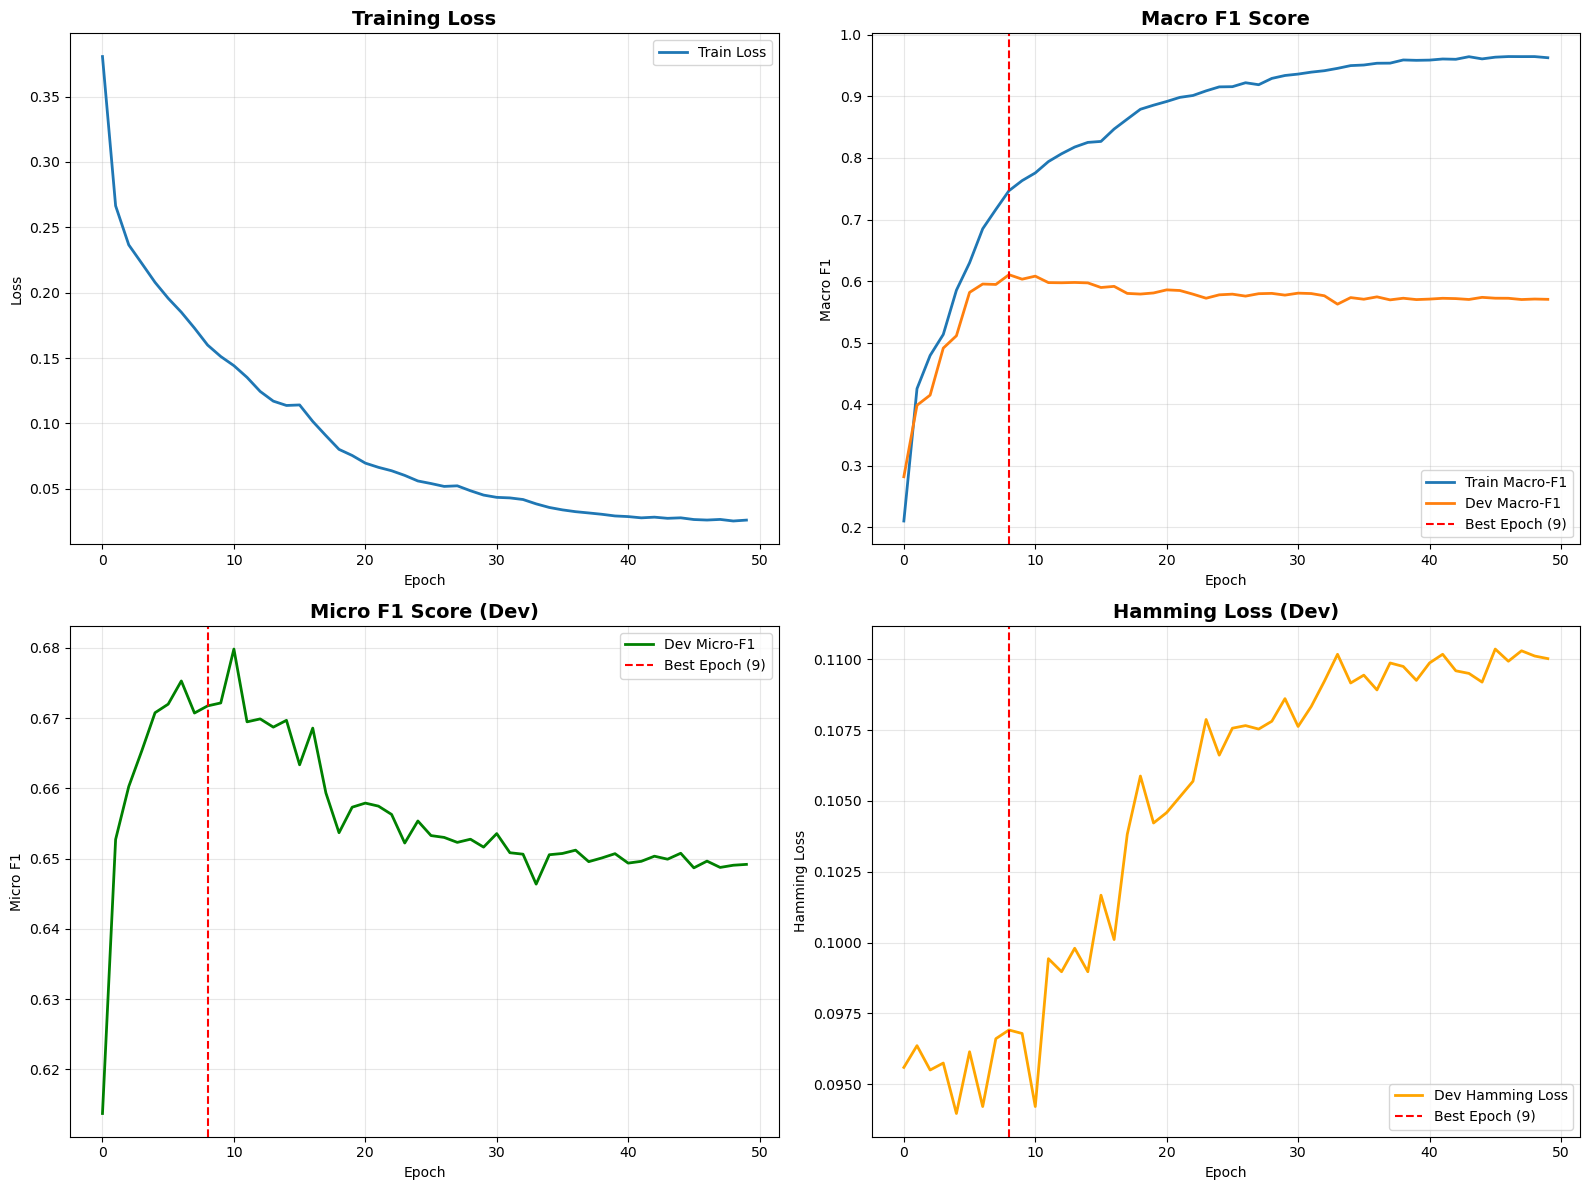

✓ Training history saved to: results/training_history_multilabel.png


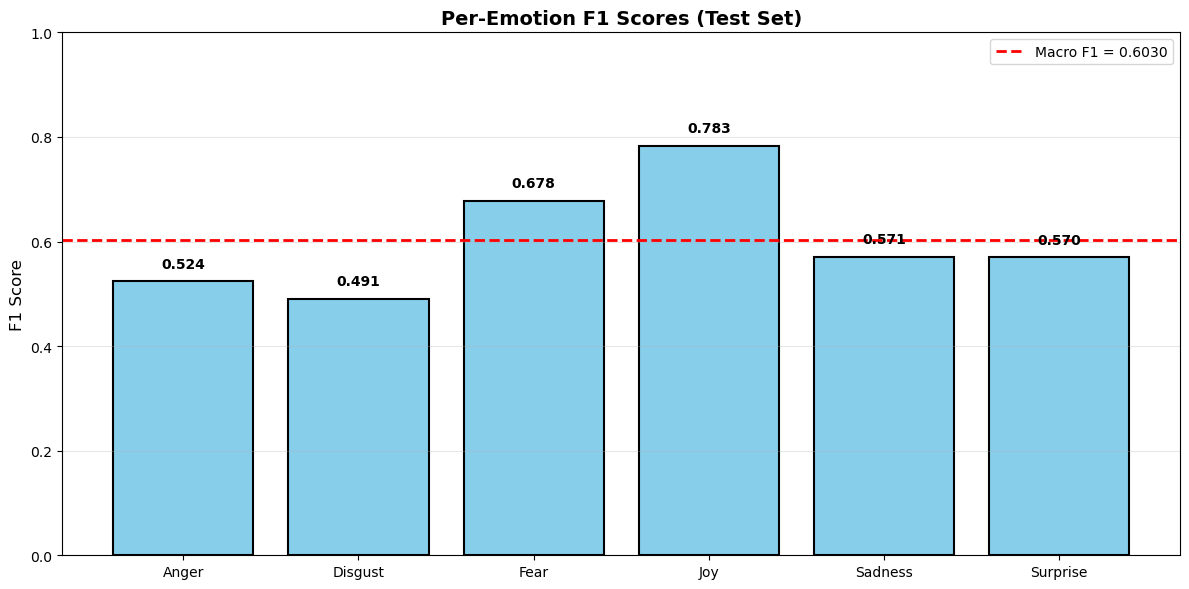

✓ Per-emotion F1 chart saved to: results/per_emotion_f1_multilabel.png


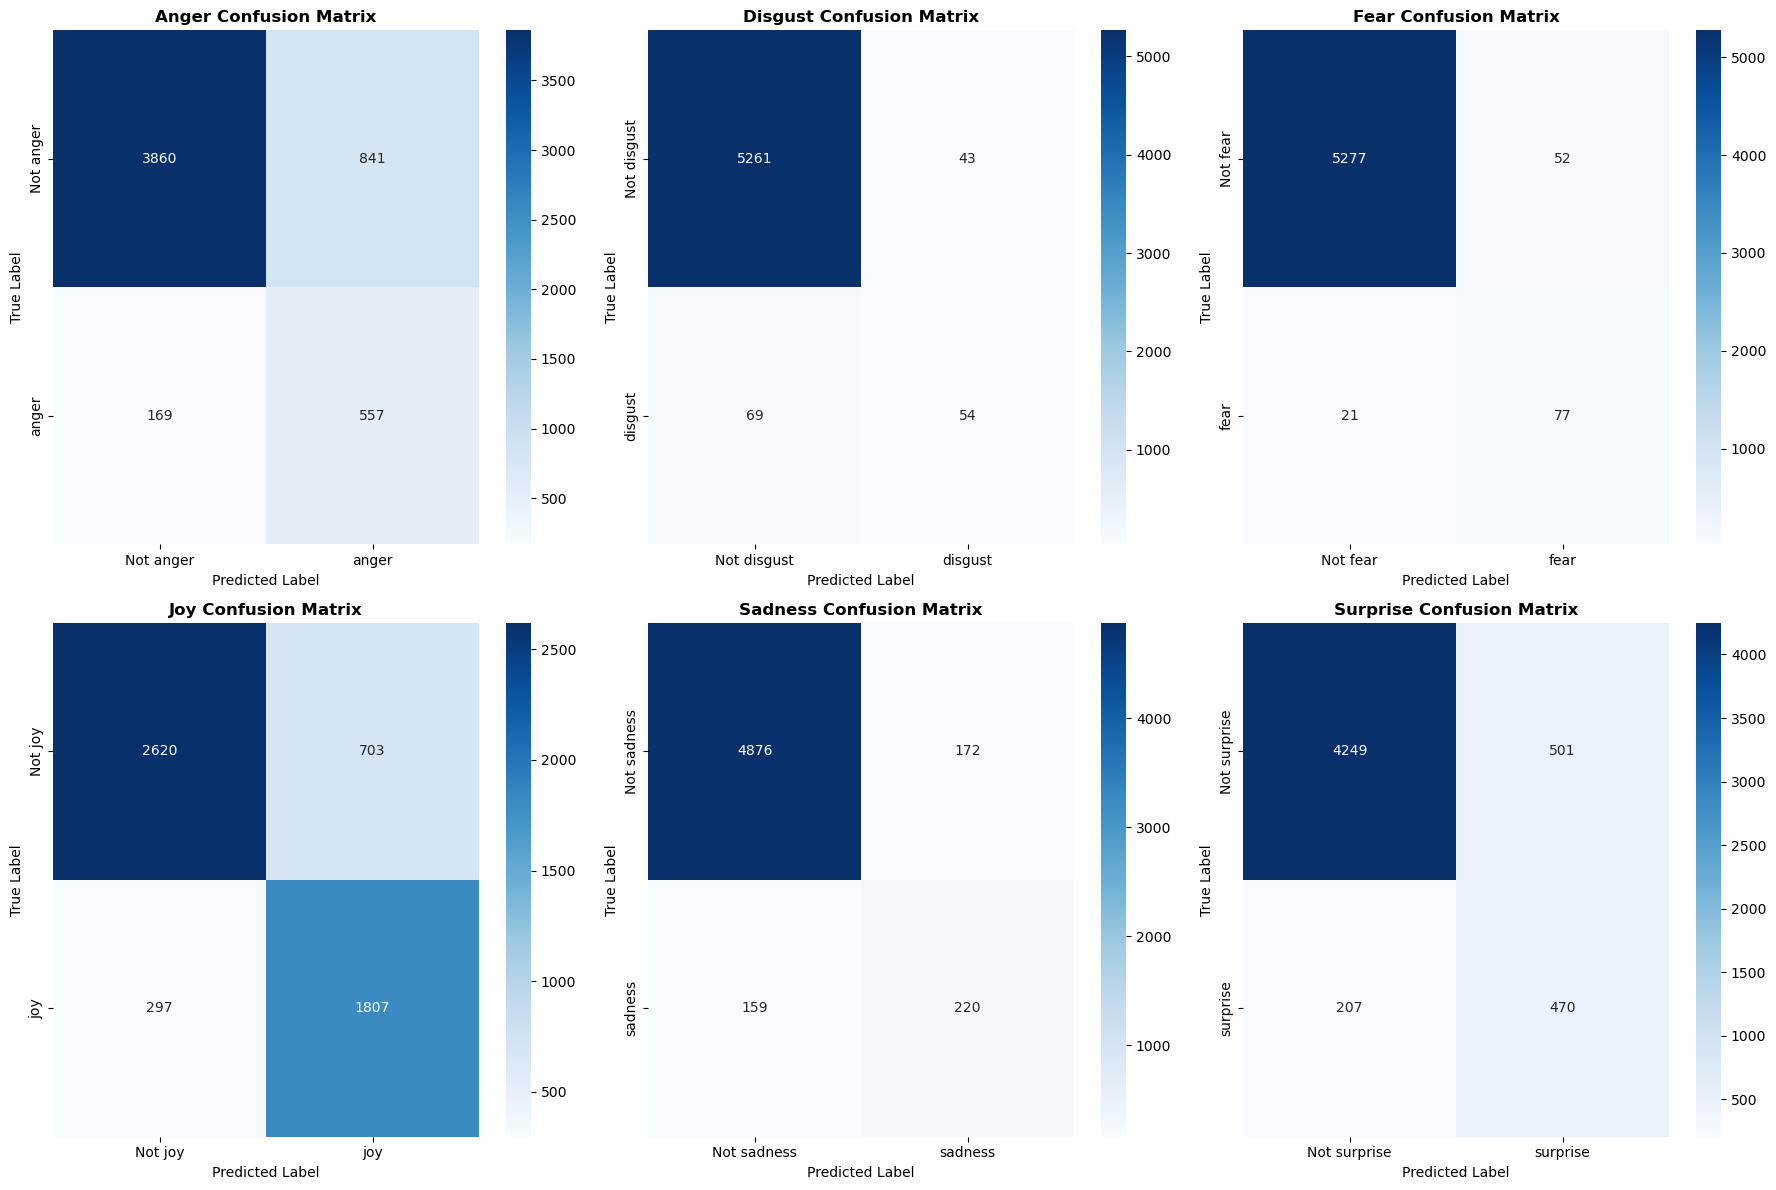

✓ Confusion matrices saved to: results/confusion_matrices_multilabel.png


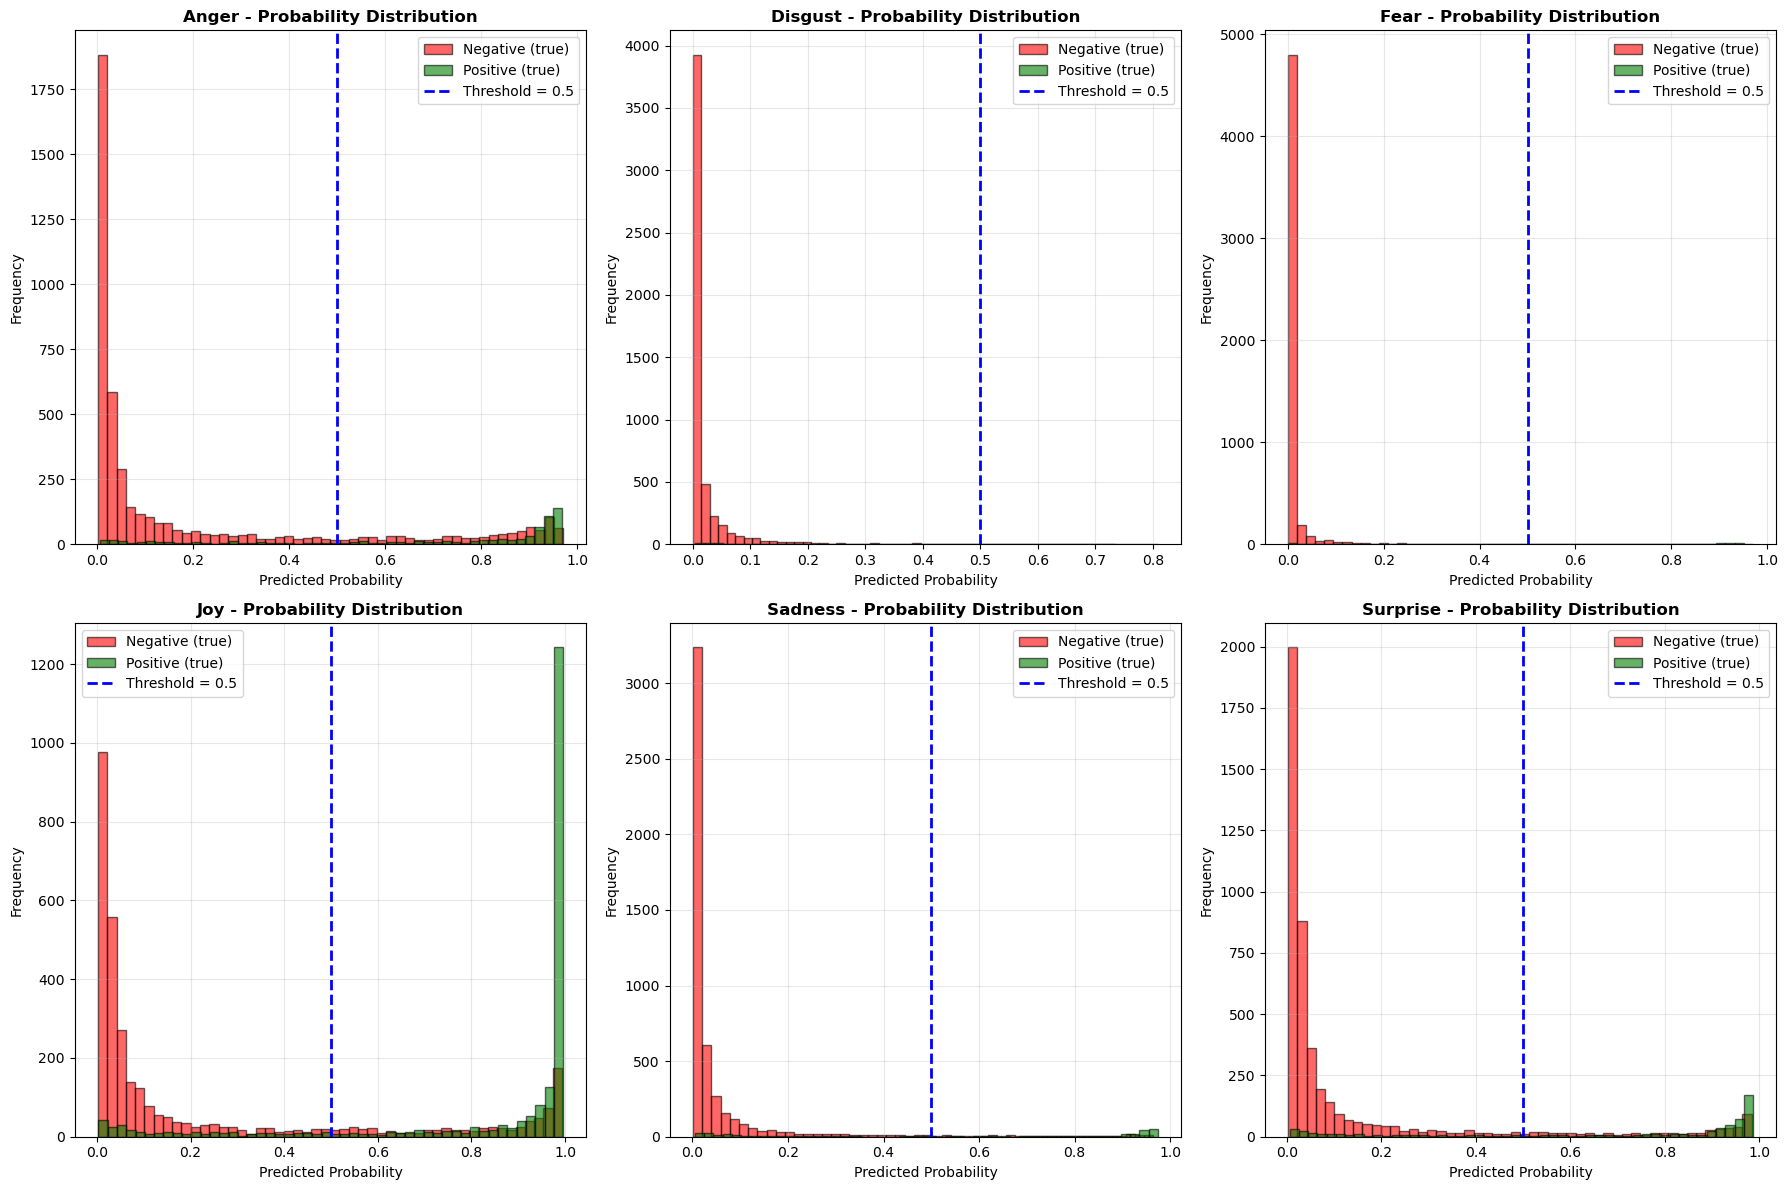

✓ Probability distributions saved to: results/probability_distributions_multilabel.png

✅ All visualizations generated!


In [14]:
# Step 8: Visualizations and Analysis
print("="*60)
print("STEP 8: VISUALIZATIONS")
print("="*60)

# 1. Training history plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Macro F1 plot
axes[0, 1].plot(history['train_macro_f1'], label='Train Macro-F1', linewidth=2)
axes[0, 1].plot(history['dev_macro_f1'], label='Dev Macro-F1', linewidth=2)
axes[0, 1].axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
axes[0, 1].set_title('Macro F1 Score', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Macro F1')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Micro F1 plot
axes[1, 0].plot(history['dev_micro_f1'], label='Dev Micro-F1', linewidth=2, color='green')
axes[1, 0].axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
axes[1, 0].set_title('Micro F1 Score (Dev)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Micro F1')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Hamming loss plot
axes[1, 1].plot(history['dev_hamming_loss'], label='Dev Hamming Loss', linewidth=2, color='orange')
axes[1, 1].axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
axes[1, 1].set_title('Hamming Loss (Dev)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Hamming Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history_multilabel.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Training history saved to: results/training_history_multilabel.png")

# 2. Per-emotion F1 scores bar chart
fig, ax = plt.subplots(figsize=(12, 6))
emotions_caps = [e.capitalize() for e in target_emotions]
f1_scores = test_metrics['per_label_f1']

bars = ax.bar(emotions_caps, f1_scores, color='skyblue', edgecolor='black', linewidth=1.5)
ax.axhline(y=test_metrics['macro_f1'], color='red', linestyle='--', linewidth=2, label=f'Macro F1 = {test_metrics["macro_f1"]:.4f}')
ax.set_title('Per-Emotion F1 Scores (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/per_emotion_f1_multilabel.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Per-emotion F1 chart saved to: results/per_emotion_f1_multilabel.png")

# 3. Confusion matrix per emotion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    y_true = test_labels[:, i]
    y_pred = test_predictions[:, i]
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Not ' + emotion, emotion],
                yticklabels=['Not ' + emotion, emotion])
    axes[i].set_title(f'{emotion.capitalize()} Confusion Matrix', fontweight='bold')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/confusion_matrices_multilabel.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Confusion matrices saved to: results/confusion_matrices_multilabel.png")

# 4. Probability distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    probs_emotion = test_probs[:, i]
    true_labels = test_labels[:, i]
    
    # Separate probabilities for positive and negative samples
    probs_positive = probs_emotion[true_labels == 1]
    probs_negative = probs_emotion[true_labels == 0]
    
    axes[i].hist(probs_negative, bins=50, alpha=0.6, label='Negative (true)', color='red', edgecolor='black')
    axes[i].hist(probs_positive, bins=50, alpha=0.6, label='Positive (true)', color='green', edgecolor='black')
    axes[i].axvline(x=FIXED_PARAMS['threshold'], color='blue', linestyle='--', linewidth=2, label=f'Threshold = {FIXED_PARAMS["threshold"]}')
    axes[i].set_title(f'{emotion.capitalize()} - Probability Distribution', fontweight='bold')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/probability_distributions_multilabel.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Probability distributions saved to: results/probability_distributions_multilabel.png")

print("\n✅ All visualizations generated!")

In [15]:
# Step 9: Inference Examples and Multi-Label Prediction Demo
print("="*60)
print("STEP 9: INFERENCE DEMO")
print("="*60)

def predict_emotions(text, model, tokenizer, threshold=0.5, device='cuda'):
    """
    Predict emotions for a given text using multi-label classification
    
    Args:
        text: Input text string
        model: Trained BERT model
        tokenizer: BERT tokenizer
        threshold: Probability threshold for prediction (default 0.5)
        device: Device to run inference on
    
    Returns:
        Dictionary with emotions and probabilities
    """
    # Preprocess text
    text_clean = preprocess_text(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text_clean,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Apply sigmoid
    
    # Get predicted emotions (above threshold)
    predicted_emotions = []
    for i, prob in enumerate(probs):
        if prob > threshold:
            predicted_emotions.append(target_emotions[i])
    
    # Create results dictionary
    results = {
        'text': text,
        'predicted_emotions': predicted_emotions if predicted_emotions else ['neutral'],
        'probabilities': {emotion: float(prob) for emotion, prob in zip(target_emotions, probs)},
        'threshold': threshold
    }
    
    return results

# Test with example sentences
test_sentences = [
    "I'm so happy and excited about this! This is amazing!",
    "I'm really angry and frustrated with this situation.",
    "That's absolutely disgusting and makes me feel sick.",
    "I'm scared and worried about what might happen.",
    "I feel so sad and disappointed about everything.",
    "Wow! I didn't expect that at all! Surprising!",
    "I'm both sad and angry about how things turned out.",
    "This is joyful but also a bit scary at the same time."
]

print("\nMulti-Label Emotion Prediction Examples:")
print("="*80)

for i, sentence in enumerate(test_sentences, 1):
    result = predict_emotions(sentence, model, tokenizer, threshold=FIXED_PARAMS['threshold'], device=device)
    
    print(f"\n{i}. Text: {sentence}")
    print(f"   Predicted Emotions: {', '.join(result['predicted_emotions'])}")
    print(f"   Probabilities:")
    for emotion, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
        indicator = "✓" if emotion in result['predicted_emotions'] else " "
        print(f"      {indicator} {emotion.capitalize():<12}: {prob:.4f}")

print("\n" + "="*80)
print("✅ Inference demo completed!")

STEP 9: INFERENCE DEMO

Multi-Label Emotion Prediction Examples:

1. Text: I'm so happy and excited about this! This is amazing!
   Predicted Emotions: joy
   Probabilities:
      ✓ Joy         : 0.9927
        Surprise    : 0.0309
        Anger       : 0.0040
        Fear        : 0.0032
        Sadness     : 0.0032
        Disgust     : 0.0026

2. Text: I'm really angry and frustrated with this situation.
   Predicted Emotions: anger
   Probabilities:
      ✓ Anger       : 0.9149
        Sadness     : 0.0506
        Joy         : 0.0373
        Disgust     : 0.0368
        Fear        : 0.0139
        Surprise    : 0.0128

3. Text: That's absolutely disgusting and makes me feel sick.
   Predicted Emotions: disgust
   Probabilities:
      ✓ Disgust     : 0.7703
        Anger       : 0.1574
        Fear        : 0.1409
        Joy         : 0.1040
        Sadness     : 0.0788
        Surprise    : 0.0218

4. Text: I'm scared and worried about what might happen.
   Predicted Emotions: f

# ✅ EXPERIMENT SUMMARY

## 🎯 Model Architecture
- **Type**: Multi-Label BERT Classification
- **Base Model**: BERT-base-uncased
- **Output Layer**: 6 neurons (one per emotion)
- **Activation**: **Sigmoid** (not Softmax)
- **Loss Function**: **BCEWithLogitsLoss** (not CrossEntropyLoss)
- **Prediction Method**: Threshold-based (0.5) instead of argmax

## 📊 Key Differences from Multi-Class

| Aspect | Multi-Class (Previous) | Multi-Label (This Notebook) |
|--------|----------------------|---------------------------|
| **Output Activation** | Softmax | **Sigmoid** |
| **Loss Function** | CrossEntropyLoss | **BCEWithLogitsLoss** |
| **Label Format** | Single integer (0-5) | **Multi-hot vector [1,0,1,0,0,0]** |
| **Predictions** | One emotion only (argmax) | **Multiple emotions (threshold)** |
| **Can predict multiple emotions?** | ❌ No | **✅ Yes** |
| **Threshold tuning** | Not applicable | **✅ Tunable per label** |

## 🔑 Key Implementation Details

### 1. **Label Encoding**
```python
# Multi-class (old): single integer
label = 3  # joy

# Multi-label (new): multi-hot vector
label = [0, 0, 0, 1, 0, 0]  # joy only
label = [1, 0, 0, 0, 1, 0]  # anger + sadness
```

### 2. **Loss Calculation**
```python
# Multi-class (old)
loss = CrossEntropyLoss(logits, labels)

# Multi-label (new)
loss = BCEWithLogitsLoss(logits, labels.float())
```

### 3. **Prediction**
```python
# Multi-class (old)
pred = torch.argmax(logits, dim=1)  # Single class

# Multi-label (new)
probs = torch.sigmoid(logits)  # Apply sigmoid
preds = (probs > 0.5).int()  # Multiple classes
```

### 4. **Evaluation Metrics**
- **Macro F1**: Average F1 across all emotions
- **Micro F1**: Global F1 (counts total TP, FP, FN)
- **Weighted F1**: F1 weighted by label frequency
- **Hamming Loss**: Fraction of incorrect labels
- **Exact Match**: Percentage of samples with all labels correct
- **Per-Label F1**: Individual F1 per emotion

## 🎓 When to Use Multi-Label?

### ✅ Use Multi-Label When:
- Text can express **multiple emotions simultaneously**
- Example: "I'm sad and angry" → [anger=1, sadness=1]
- Want to capture **emotional complexity**
- Have multi-labeled training data

### ❌ Use Multi-Class When:
- Each text has **only one dominant emotion**
- Want to force model to choose **single best emotion**
- Labels are mutually exclusive
- Simpler interpretation needed

## 📈 Expected Benefits

1. **Better Multi-Emotion Detection**: Can detect "sad and angry" instead of picking one
2. **More Accurate Representation**: Captures emotional complexity
3. **Improved Recall**: Won't miss secondary emotions
4. **Flexible Thresholding**: Can tune per-emotion thresholds

## ⚠️ Potential Challenges

1. **More Complex Evaluation**: Need multi-label metrics
2. **Threshold Tuning**: Need to optimize threshold (default 0.5)
3. **Class Imbalance**: Some emotion combinations rare
4. **Computational Cost**: Same as multi-class (6 outputs)

## 🔄 Next Steps

1. **Threshold Optimization**: Tune threshold per emotion
2. **Error Analysis**: Analyze mispredictions
3. **Comparison**: Compare with 6 binary models approach
4. **A/B Testing**: Use in chatbot for emotion-based responses

---

**✅ Notebook Complete!**

All code uses **Sigmoid + BCEWithLogitsLoss** for proper multi-label classification.
Model can now predict **multiple emotions** from a single text.